In [2]:
import pandas as pd
import glob
import os
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import ruptures as rpt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy import signal

# setup matplotlib
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = (16, 4)
plt.rcParams['figure.dpi'] = 100

In [3]:
from scipy import signal

def butter_highpass(cut=0.5, order=5):
    b, a = signal.butter(order, cut, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cut, order=5):
    b, a = butter_highpass(cut, order=order)
    y = signal.filtfilt(b, a, data, axis=0)
    return y

def plot_change_points(ts_change_loc, color='red', alpha=1):
    for x in ts_change_loc:
        plt.axvline(x, lw=2, linestyle='--', color=color, alpha=alpha)

def classify_signal(seq_encoder, change_loc, envelope_indices, encoder_threshold=3.0):
    """This function removes redundant interval generated from change point detection algorithm (CPA).
    Ex: CPA based on mean, variance of encoder signal to classify interval into high or low frequency, [high, high, low, high,...]
    Since there some adjacent high interval, it should belong to 1 high/low interval. This function remove that adjacent
    Resulted in [high, low, high,...]

    change_loc: list - index of interval
    """
    signal_state = []
    change_loc = [loc for loc in change_loc if loc[0]!=loc[1]]

    for idx, val in enumerate(change_loc):

        low_idx_interval = envelope_indices[(envelope_indices >= val[0]) & (envelope_indices <= val[1])]
        # print(low_idx_interval, )

        if np.mean(seq_encoder[low_idx_interval]) >= encoder_threshold:
            state = 'high'  # current state of signal as high
        else:
            state = 'low'  # current state of signal as low

        signal_state.append(state)

    return signal_state

def remove_redundant_loc(change_loc, signal_state):
    new_loc = [0]
    current_state = signal_state[0]
    signal_state_removed = [current_state]

    for idx, val in enumerate(signal_state):
        if val != current_state:
            new_loc.append(change_loc[idx][0])
            signal_state_removed.append(val)

            current_state = val

    return new_loc, make_crop_index(new_loc), signal_state_removed

def make_crop_index(change_location):
    # create function to crop window
    crop_window = []
    for i in range(len(change_location)):
        if i == 0:
            crop_window.append([0, change_location[i]])
            continue

        crop_window.append([change_location[i - 1], change_location[i]])

    return crop_window

In [4]:
def hl_envelopes_idx(s, dmin=1, dmax=1, split=False):
    """
    Input :
    s: 1d-array, data signal from which to extract high and low envelopes
    dmin, dmax: int, optional, size of chunks, use this if the size of the input signal is too big
    split: bool, optional, if True, split the signal in half along its mean, might help to generate the envelope in some cases
    Output :
    lmin,lmax : high/low envelope idx of input signal s
    """

    # locals min
    lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1
    # locals max
    lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1


    if split:
        # s_mid is zero if s centered around x-axis or more generally mean of signal
        s_mid = np.mean(s)
        # pre-sorting of locals min based on relative position with respect to s_mid
        lmin = lmin[s[lmin]<s_mid]
        # pre-sorting of local max based on relative position with respect to s_mid
        lmax = lmax[s[lmax]>s_mid]


    # global max of dmax-chunks of locals max
    lmin = lmin[[i+np.argmin(s[lmin[i:i+dmin]]) for i in range(0,len(lmin),dmin)]]
    # global min of dmin-chunks of locals min
    lmax = lmax[[i+np.argmax(s[lmax[i:i+dmax]]) for i in range(0,len(lmax),dmax)]]

    return lmin, lmax

In [4]:
link_to_dataset = 'Test_011454.csv'
df = pd.read_csv(link_to_dataset, header=None, index_col=0).reset_index().drop([0, 4], axis=1)

In [5]:
df_x = df[1]
df_piezo = df[2]
df_z = df[3]

In [18]:
df_z.shape

(600200,)

In [17]:
start, end = 0, 600200
plt.figure(figsize=(150, 5), dpi=100)
plt.plot(df_x[start: end])
plt.plot(df_z[start: end])
plt.plot(df_piezo[start: end])
plt.savefig('overall_data')
plt.close()

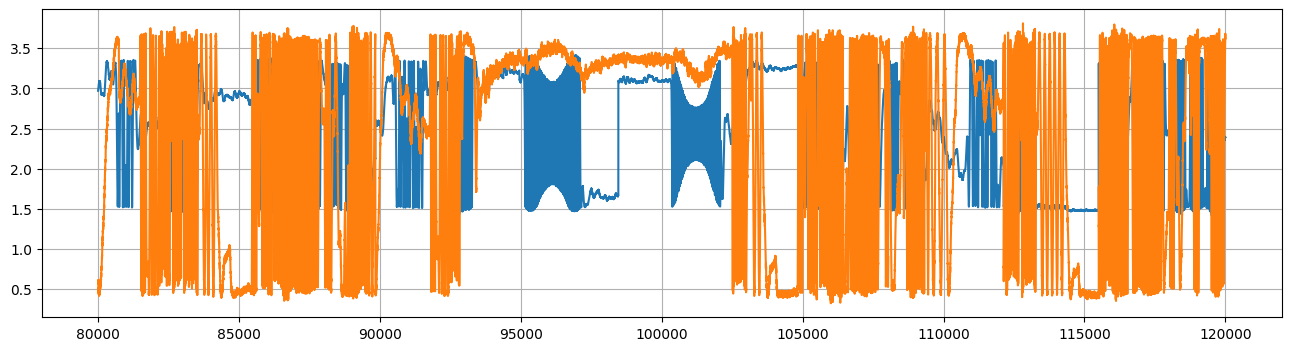

In [24]:
plt.plot(df_x[80000: 120000])
plt.plot(df_z[80000: 120000])

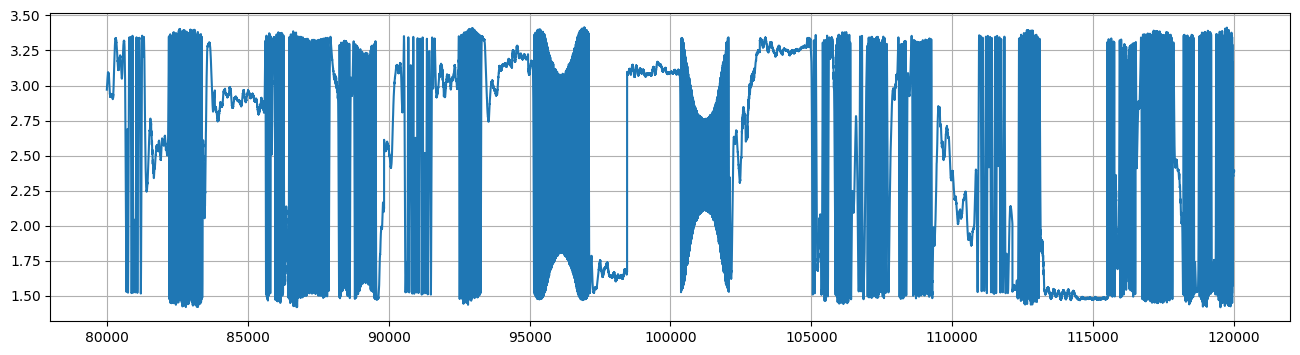

In [25]:
plt.plot(df_x[80000: 120000])

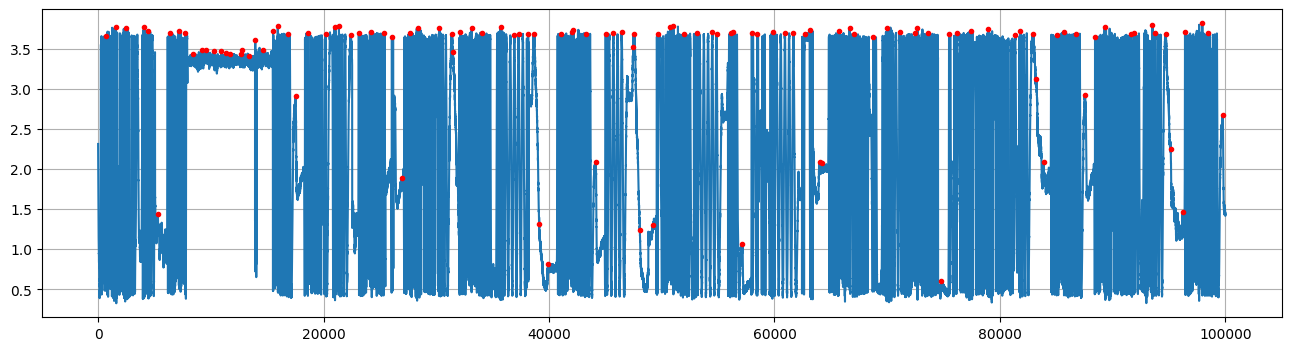

In [30]:
high_idx, low_idx = hl_envelopes_idx(df_z_sample.values, dmin=200, dmax=200)

t = np.array([i for i in range(len(df_z_sample))])

plt.plot(df_z_sample.values, label='signal')
# plt.plot(t[high_idx], df_z[50000:80000].values[high_idx], 'r', label='low')
plt.plot(t[low_idx], df_z_sample.values[low_idx], 'r', label='high', marker='.', linestyle=' ')

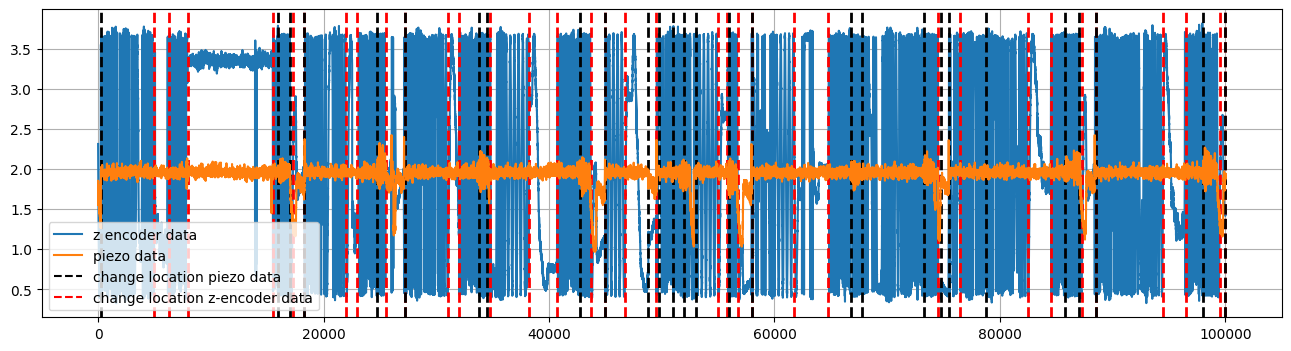

In [20]:
start, end = 250000, 350000
df_z_sample = df_z[start: end]
df_piezo_sample = df_piezo[start: end]

plt.plot(df_z_sample.values, label='z encoder data')

indices = [i for i in range(0, len(df_z_sample), 50)]

# ========= Plot for z encoder sensor data
z_normalize = butter_highpass_filter(data=df_z_sample, cut=0.005, order=2)

sampling_z = np.take(z_normalize, indices)
alg_z = rpt.Pelt(model="rbf").fit(sampling_z)
change_loc_z = np.array(alg_z.predict(pen=2.5))*50

plot_change_points(change_loc_z)

# ========= Plot for piezo sensor data
sampling_piezo = np.take(df_piezo_sample.values, indices)
alg_piezo = rpt.Pelt(model="rbf").fit(sampling_piezo)
change_loc_piezo = np.array(alg_piezo.predict(pen=2.5))*50

plot_change_points(change_loc_piezo, color='black')

# Plot
plt.plot(df_piezo_sample.values, label='piezo data')
plt.plot([], [], label='change location piezo data', linestyle='--', color='black')
plt.plot([], [], label='change location z-encoder data', linestyle='--', color='red')
plt.legend()
plt.show()

[3.31604 2.09778 1.65131 1.12244 0.80353 0.73517 3.70209 0.48218 0.48096
 0.51605 0.5011  0.49774] 1.3255325


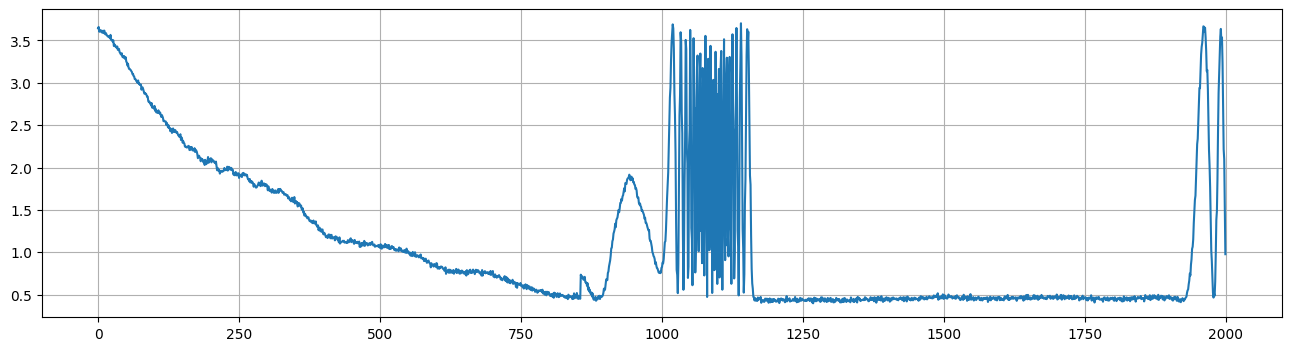

In [132]:
plt.plot(df_z_sample[6750: 8750].values)
low_idx_interval = low_idx[(low_idx >= 6750) & (low_idx <= 8750)]
print(df_z_sample.values[low_idx_interval], np.mean(df_z_sample.values[low_idx_interval]))

In [128]:
print(low_idx_interval)

[6796 6952 7098 7236 7385 7606 7890 7971 8139 8239 8450 8630]


[3.69507 3.6731  3.65845 3.71948 3.75366 3.71643 3.72162 3.67859 3.67828
 3.69629 3.69995] 3.6991745454545453


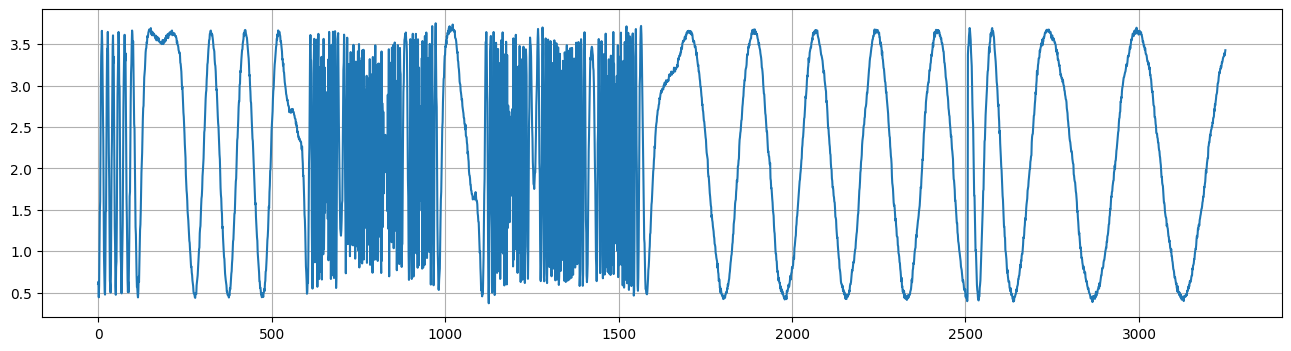

In [133]:
plt.plot(df_z_sample[8750: 12000].values)
low_idx_interval = low_idx[(low_idx >= 8750) & (low_idx <= 12000)]
print(df_z_sample.values[low_idx_interval], np.mean(df_z_sample.values[low_idx_interval]))

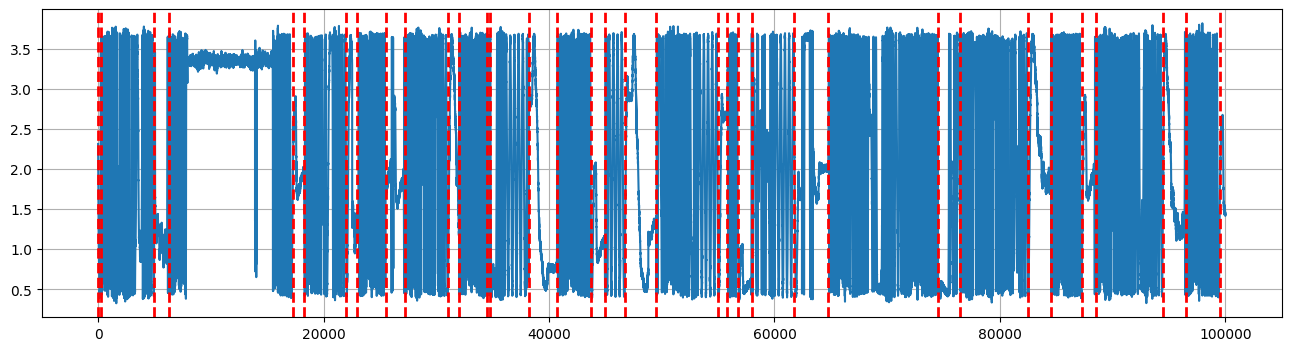

In [24]:
def extend_envelope(df_np, env_indices_np):

    extend_list = []

    for idx, val in enumerate(env_indices_np):
        if idx == len(env_indices_np)-1:
            extend_list.extend([val for _ in range(len(df_np) - val)])
            return np.array(extend_list)
        if idx == 0 and env_indices_np[0] != 0:
            extend_list.extend([val for _ in range(val)])
        else:
            extend_list.extend([val for _ in range(env_indices_np[idx+1] - val)])

    return np.array(extend_list)

change_loc_sum = np.unique(np.sort(np.concatenate((change_loc_z, change_loc_piezo), axis=None)))
crop_window = make_crop_index(change_loc_sum)

high_envelope_indices, low_envelope_indices = hl_envelopes_idx(df_z_sample.values, dmin=50, dmax=50)
extend_low_envelope = extend_envelope(df_z_sample.values, low_envelope_indices)
signal_state = classify_signal(df_z[start: end].values, crop_window, extend_low_envelope, encoder_threshold=3.0)

new_loc, new_crop, signal_state_removed = remove_redundant_loc(crop_window, signal_state)
plt.plot(df_z[start: end].values)
plot_change_points(new_loc)
# plot_change_points(change_loc_sum, color='black', alpha=0.5)

121


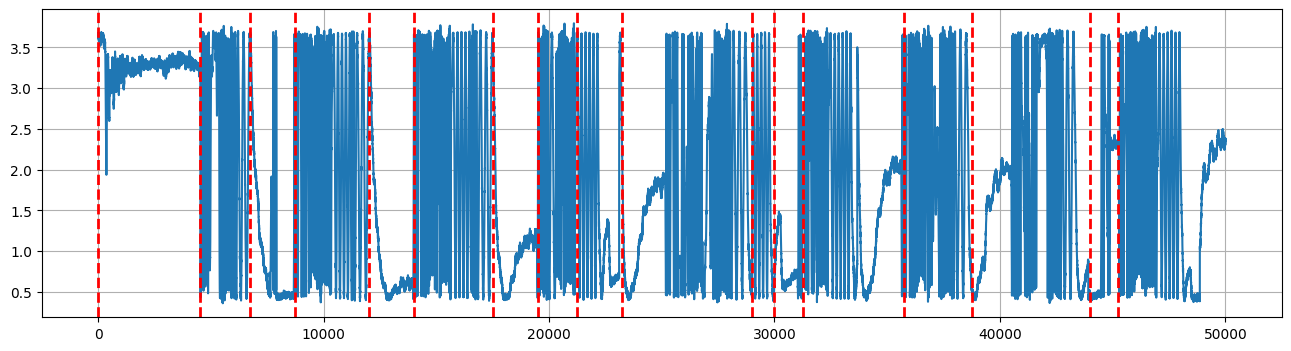

In [195]:
def extend_envelope(df_np, env_indices_np):
    extend_list = []

    for idx, val in enumerate(env_indices_np):
        if idx == len(env_indices_np)-1:
            extend_list.extend([df_np[val] for _ in range(len(df_np) - val)])
            return extend_list
        if idx == 0 and env_indices_np[0] != 0:
            extend_list.extend([df_np[val] for _ in range(val)])
        else:
            extend_list.extend([df_np[val] for _ in range(env_indices_np[idx+1] - val)])

change_loc_sum = np.sort(np.concatenate((change_loc_z, change_loc_piezo), axis=None))
crop_window = make_crop_index(change_loc_sum)

high_envelope_indices, low_envelope_indices = hl_envelopes_idx(df_z_sample.values, dmin=50, dmax=50)
# extend_low_envelope = extend_envelope(df_z_sample.values, low_envelope_indices)
signal_state = classify_signal(df_z[start: end].values, crop_window, low_envelope_indices, encoder_threshold=3.5)

new_loc, new_crop, signal_state_removed = remove_redundant_loc(crop_window, signal_state)
plt.plot(df_z[start: end].values)
plot_change_points(new_loc)

In [ ]:
np.array([df_z[start: end].values[low_envelope_indices], low_envelope_indices])

In [184]:
print(len(extend_low_envelope))

6274839


In [ ]:
var, max_min = [], []
crop_window = [window for window in crop_window if window[0]!=window[1]]

for window in crop_window:
    if window[0] - window[1] != 0:
        normalize = butter_highpass_filter(data=df_z[start: end].values[window[0]: window[1]], cut=0.1, order=2)
        print(f'{window}, variance = {round(np.var(normalize), 3)}, max-min = {round(np.max(normalize)-np.min(normalize), 3)}')
        var.append(np.var(normalize))
        max_min.append(np.max(normalize)-np.min(normalize))

In [ ]:
dict_win = {'index': crop_window,
            'var': var,
            'max_min': max_min}

window_variable = pd.DataFrame(dict_win)
window_variable

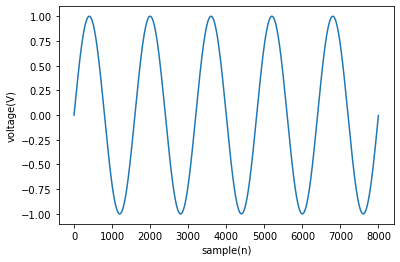

In [1]:
import matplotlib.pyplot as plt
import numpy as np

Fs = 8000
f = 5
sample = 8000
x = np.arange(sample)
y = np.sin(2 * np.pi * f * x / Fs)
plt.plot(x, y)
plt.xlabel('sample(n)')
plt.ylabel('voltage(V)')
plt.show()

In [2]:
(np.diff(np.sign(np.diff(y))) > 0).nonzero()[0] + 1

array([1200, 2800, 4400, 6000, 7600], dtype=int64)

In [4]:
(np.diff(np.sign(np.diff(y))) < 0).nonzero()[0] + 1

array([ 400, 2000, 3600, 5200, 6800], dtype=int64)

In [12]:
(np.diff(np.sign(np.diff(y)))>0).nonzero()[0] + 1

array([1200, 2800, 4400, 6000, 7600], dtype=int64)